# Re-useable Component: Multi-line time series plot

This component is defined with the following parts:  

1. **data**: the data to be plotted is in a dataframe where the first column is the x-axis and the remaining columns are values to be plotted on the y-axis 
2. **settings**: dictionary for all annotations and stylings, e.g. axis labels, shaded areas, colours, text rotation angle, etc.  


In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import math
# import rick
import geopandas as gpd
import os
import shapely
from shapely.geometry import Point
#os.environ["PROJ_LIB"]=r"C:\Users\rliu4\AppData\Local\Continuum\anaconda3\Library\share"
import importlib
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.dates as mdates
from matplotlib.lines import Line2D # for legend

import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Palette
Might be useful to have a collection of colours.   

In [3]:
# Line colours
rick_purple='#660159'
rick_purple_light='#d1b2cd'
rick_grey='#7f7e7e' # colour.grey
rich_orange='#D95F02'
rich_orange_light='#F3CAAC'

# Shaded area colours
rich_facecolour='#e1e1e1'

In [4]:
class font:
    """
    Class defining the global font variables for all functions.
    """
    leg_font = font_manager.FontProperties(family='Libre Franklin',size=9)
    normal = 'Libre Franklin'
    semibold = 'Libre Franklin SemiBold'
    
mpl.rc('font',family='Libre Franklin')    

# Multi-line reusable component

In [5]:
# font_manager.FontProperties(family='Libre Franklin',size=9)

In [6]:
def multi_linechart(df_orig, sett):
    '''Creates a line chart. Number of lines to be plotted determined
    from input data.
    x axis must be modified manually
    
    Parameters
    -----------
    df : pandas dataframe
        Data for the line chart.
    sett: settings object containing styling and annotation parameters      
    
    Optional params:
    
    
    Returns 
    --------
    fig
        Matplotlib fig object
    ax 
        Matplotlib ax object
 
    ''' 
    df=df_orig.copy()
    
    # ----------------------------------------------
    # Setup the figure
    fig, ax =plt.subplots(1)
    fig.set_size_inches(18, 5)
    ax = plt.gca()
    
    
    # ----------------------------------------------
    # Default styling params if not defined in sett
    dflt={
        'font-size':(12 if 'font-size' not in sett['body']
                     else sett['body']['font-size']),
        'stroke':('#000000' if 'stroke' not in sett['body']
                     else sett['body']['stroke']),
        'stroke-width':(2 if 'stroke-width' not in sett['body']
                     else sett['body']['stroke-width']),
        'border':('solid' if 'border' not in sett['body']
                     else sett['body']['border'])
    }
 
    
    mpl.rcParams['axes.linewidth'] = 0.3
#     mpl.rcParams['font.family'] = ('Libre Franklin' if 'font-family' not in 
#                                   sett['body'] else sett['body']['font-family'])
    mpl.rcParams.update({'font.size': 14})
    
    
    # ----------------------------------------------
    # Define line-number-dependent params
    num_lines=len(sett['lines'].keys())
    
    col_names=['xcol']
    ymax_array=[]
    for n in range(num_lines):
        col_names.append('ycol_' + str(n))
        ymax_array.append(df.iloc[:,n+1].max())
        
    df.columns=col_names
    
    # ----------------------------------------------
    # title
    if 'title' in sett:
        if 'title_params' in sett:
            title_size=(
                dflt['font-size'] if 'font-size' not in 
                sett['title_params']
                else sett['title_params']['font-size'])
            loc=('center' if 'loc' not in sett['title_params']
                 else sett['title_params']['loc'])
        ax.set_title(sett['title'], fontsize=title_size,  loc=loc)
    
    # ----------------------------------------------
    # grid
    if 'major_grid_on' in sett and sett['major_grid_on']==True:      
        if 'major_grid' in sett:
            c=('gray' if 'stroke' not in sett['major_grid']
               else sett['major_grid']['stroke'])
            b=('-' if 'border' not in sett['major_grid']
               else sett['major_grid']['border'])
        else: 
            c='gray'
            b='-'
        plt.grid(b=True, which='major', color=c, linestyle=b)
    if 'minor_grid_on' in sett and sett['minor_grid_on']==True:      
        if 'minor_grid' in sett:
            c=('gray' if 'stroke' not in sett['minor_grid']
               else sett['minor_grid']['stroke'])
            b=('-' if 'border' not in sett['minor_grid']
               else sett['minor_grid']['border'])
        else: 
            c='gray'
            b='-'
        plt.grid(b=True, which='minor', color=c, linestyle=b)

    
    # ----------------------------------------------
    # axes (both)
    ticklength=2 if 'ticklength' not in sett else sett['ticklength']
    tickwidth=1 if 'tickwidth' not in sett else sett['tickwidth']
    ax.tick_params(width=tickwidth, length=ticklength)
    
    # y-axis
    if 'yaxis' in sett:
        ymin=(0 if 'ymin' not in sett['yaxis']
              else sett['yaxis']['ymin'])
        ymax=(np.max(ymax_array)*(1 + 0.1) if 'ymax'
              not in sett['yaxis']
              else sett['yaxis']['ymax'])
        
        # y-axis label
        label=('' if 'label' not in sett['yaxis']
               else sett['yaxis']['label'])
        labelsize=(dflt['font-size'] if 'labelsize'
                   not in sett['yaxis']
                   else sett['yaxis']['labelsize'])
        plt.ylabel(label, fontsize=labelsize)
        
        # Format y-axis ticks
        ticksize=(dflt['font-size'] if 'ticksize'
                  not in sett['yaxis']
                  else sett['yaxis']['ticksize'])
        ax.tick_params(axis='y', labelsize=ticksize)
        
        # comma format
        precision=('.0f' if 'precision'
                   not in sett['yaxis']
                   else sett['yaxis']['precision'])
        ax.yaxis.set_major_formatter(
            mpl.ticker.StrMethodFormatter('{x:,' + precision + '}')
        )
    else:
        ymin=0
        ymax=np.max(ymax_array)*(1 + 0.1)
        
        # Default y-axis formats
        ax.tick_params(axis='y', labelsize=dflt['font-size'])
        ax.yaxis.set_major_formatter(
            mpl.ticker.StrMethodFormatter('{x:,.0f}') # comma format
        ) 
          
    delta = (ymax - ymin)/4
    i = 0
    while True:
        delta /= 10
        i += 1
        if delta < 10:
            break
    if 'yinc' in sett:
        yinc=sett['yinc']
    else:
        yinc = int(round(delta+1)*pow(10,i))
                   
    plt.ylim(top=ymax, bottom=ymin)
    
    # ----------------------------------------------
    # x-axis
    if 'xaxis' in sett:
        
        # x-axis label
        if 'label' in sett['xaxis']:
            label=sett['xaxis']['label']
            labelsize=(dflt['font-size'] if 'labelsize'
                       not in sett['xaxis']
                       else sett['xaxis']['labelsize'])
            plt.xlabel(label, fontsize=labelsize)
        
        # x-axis tick labels
        if 'major_loc' in sett['xaxis']: # x-values are dates  
            date_form_mjr = sett['xaxis']['major_loc']['date_form']
            ax.xaxis.set_major_formatter(date_form_mjr)
        if 'minor_loc' in sett['xaxis']:
            date_form_mnr = sett['xaxis']['minor_loc']['date_form']
            ax.xaxis.set_minor_locator(date_form_mnr)
        
        # x-axis tick lines
        ticksize=(dflt['font-size'] if 'ticksize'
                  not in sett['xaxis']
                  else sett['xaxis']['ticksize'])
        ax.tick_params(axis='x', labelsize=ticksize, 
                       labelbottom=True)
    else:
        # Default x-axis tick lines
        ax.tick_params(axis='x', labelsize=dflt['font-size'],
                       labelbottom=True)
        

    # ----------------------------------------------
    # Plot data and legend
    if 'legend' in sett:
        legend_loc=('upper left' if 'loc' not in sett['legend']
                    else sett['legend']['loc'])
        leg_array=[]
        custom_lines=[]
        
    for n in range(num_lines):
        line_colour=(dflt['stroke'] if 'stroke' not in 
                     sett['lines'][n] 
                     else sett['lines'][n]['stroke'])
        line_width=(dflt['stroke-width'] if 'stroke-width' 
                    not in sett['lines'][n] 
                    else sett['lines'][n]['stroke-width'])
        border_style=(dflt['border'] if 'border-style' not in 
                      sett['lines'][n] 
                      else sett['lines'][n]['border-style'])
        
        ax.plot(df['xcol'], df['ycol_' + str(n)], linewidth=line_width, 
                color = line_colour, linestyle=border_style)
        
        # Legend
        if 'legend' in sett:
            leg_array.append(sett['lines'][n]['label'])
            custom_lines.append(Line2D([0], [0], 
                                       color=line_colour, 
                                       lw=line_width,
                                       linestyle=border_style)
                               )
    
    if 'legend' in sett:
        ax.legend(custom_lines, leg_array, loc=legend_loc, 
                  prop={"size": dflt['font-size']},
                  ncol=len(df.columns))

    
    # ----------------------------------------------
    # Plot shaded areas
    if 'shaded' in sett:
        num_a=len(sett['shaded'].keys())
        
        for area in range(num_a):
            idx=sett['shaded'][area]['lims']
            facecolour=sett['shaded'][area]['fill']
            zorder=(0 if 'zorder' not in sett['shaded'][area] 
                    else sett['shaded'][area]['zorder'])
            alpha=(1 if 'alpha' not in sett['shaded'][area]
                   else sett['shaded'][area]['alpha'])
            
            # Shaded area left and right bds
            for i in range(len(idx)):
                bd1=idx[i][0]
                bd2=idx[i][1]
                
                ax.axvspan(bd1, bd2, facecolor=facecolour, 
                           edgecolor='none', alpha=alpha,
                           zorder=zorder)
            
            # Shaded area label
            if 'label' in sett['shaded'][area]:
                rot=(0 if 'rotation' not in 
                     sett['shaded'][area]['label'] 
                     else sett['shaded'][area]['label']['rotation'])
                label_colour=(dflt['stroke'] if 'colour' not in 
                              sett['shaded'][area]['label'] 
                              else sett['shaded'][area]['label']['colour'])
                label_size=(dflt['font-size'] if 'font-size' not in 
                            sett['shaded'][area]['label'] 
                            else sett['shaded'][area]['label']['font-size'])
                plt.text(                    
                    sett['shaded'][area]['label']['x'], # x posn of label
                    sett['shaded'][area]['label']['y'], # y posn of label
                    sett['shaded'][area]['label']['text'], 
                    rotation=rot, 
                    color=label_colour, 
                    fontsize=label_size
                )

    return fig, ax

# 1. Demo dataset 1: Time series, dt=day
*Recall: `multi_linechart()` expects dataframe with first column for the x-axis and subsequent columns for plotting on the y-axis.*  

Demo dataset 1 is a time series of interval one day. The x-axis labels will display major formatters at mid-month with tick label format `2020-mm-dd` and minor formatters at every other day with no labels.   

In [7]:
# x-axis
dt=[datetime.date(2020, 10, 27), datetime.date(2020, 10, 28), datetime.date(2020, 10, 29), 
    datetime.date(2020, 10, 30), datetime.date(2020, 10, 31), datetime.date(2020, 11, 1), 
    datetime.date(2020, 11, 2), datetime.date(2020, 11, 3), datetime.date(2020, 11, 4), 
    datetime.date(2020, 11, 5), datetime.date(2020, 11, 6), datetime.date(2020, 11, 7), 
    datetime.date(2020, 11, 8), datetime.date(2020, 11, 9), datetime.date(2020, 11, 10), 
    datetime.date(2020, 11, 11), datetime.date(2020, 11, 12), datetime.date(2020, 11, 13), 
    datetime.date(2020, 11, 14), datetime.date(2020, 11, 15), datetime.date(2020, 11, 16), 
    datetime.date(2020, 11, 17), datetime.date(2020, 11, 18), datetime.date(2020, 11, 19), 
    datetime.date(2020, 11, 20), datetime.date(2020, 11, 21), datetime.date(2020, 11, 22), 
    datetime.date(2020, 11, 23), datetime.date(2020, 11, 24), datetime.date(2020, 11, 25), 
    datetime.date(2020, 11, 26), datetime.date(2020, 11, 27), datetime.date(2020, 11, 28), 
    datetime.date(2020, 11, 29), datetime.date(2020, 11, 30), datetime.date(2020, 12, 1), 
    datetime.date(2020, 12, 2), datetime.date(2020, 12, 3), datetime.date(2020, 12, 4), 
    datetime.date(2020, 12, 5), datetime.date(2020, 12, 6), datetime.date(2020, 12, 7), 
    datetime.date(2020, 12, 8), datetime.date(2020, 12, 9), datetime.date(2020, 12, 10), 
    datetime.date(2020, 12, 11), datetime.date(2020, 12, 12), datetime.date(2020, 12, 13)]

In [8]:
# y-axis
# line 1
y1=[32512.0, 34852.0, 35136.0, 38154.0, 35551.0, 27617.0, 33677.0, 34163.0, 34606.0, 35106.0, 38034.0, 36077.0, 30372.0, 34616.0, 34264.0, 34162.0, 34891.0, 36871.0, 34465.0, 25836.0, 41818.0, 42943.0, 42199.0, 44307.0, 49460.0, 47071.0, 31263.0, 38039.0, 39162.0, 29431.0, 42445.0, 45586.0, 42333.0, 35198.0, 39244.0, 38740.0, 41345.0, 43083.0, 43299.0, 41210.0, 32797.0, 40363.0, 41577.0, 38094.0, 43813.0, 46515.0, 38156.0, 28232.0]

# line 2
y2=[38781.0, 41387.0, 40545.0, 42473.0, 35726.0, 28066.0, 36873.0, 38191.0, 39432.0, 40123.0, 42199.0, 37404.0, 32564.0, 38425.0, 40460.0, 39506.0, 39780.0, 40666.0, 34904.0, 25290.0, 35852.0, 37037.0, 36880.0, 38007.0, 40274.0, 35163.0, 23323.0, 33689.0, 35129.0, 12352.0, 36524.0, 38759.0, 32995.0, 29132.0, 33974.0, 32964.0, 35851.0, 37296.0, 36458.0, 31332.0, 26148.0, 34649.0, 35588.0, 34950.0, 36615.0, 38317.0, 29245.0, 21929.0]

# line 3
y3=[21713.0, 23644.0, 22949.0, 24473.0, 21201.0, 16189.0, 21592.0, 21946.0, 23200.0, 23324.0, 25188.0, 23107.0, 20544.0, 23035.0, 24334.0, 23354.0, 23144.0, 23411.0, 20691.0, 14232.0, 20965.0, 21615.0, 20784.0, 21851.0, 24003.0, 20617.0, 13727.0, 19809.0, 20124.0, 8755.0, 20952.0, 22788.0, 20327.0, 17183.0, 19609.0, 19223.0, 20557.0, 21295.0, 20377.0, 17362.0, 14867.0, 19576.0, 20172.0, 19520.0, 20884.0, 22209.0, 16241.0, 12449.0]

In [9]:
data = {'dt':dt, 'y1':y1, 'y2':y2, 'y3':y3}

df_multi = pd.DataFrame(data) 

df_multi.head()

,dt,y1,y2,y3
0,2020-10-27,32512.0,38781.0,21713.0
1,2020-10-28,34852.0,41387.0,23644.0
2,2020-10-29,35136.0,40545.0,22949.0
3,2020-10-30,38154.0,42473.0,24473.0
4,2020-10-31,35551.0,35726.0,21201.0


## Example: one shaded area with legend

In [10]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'yaxis': {
        'label': 'Daily Volume'
    },
    'xaxis': {
        'ticksize': 8,
        'major_loc': {
            'loc': mdates.DayLocator(),
            'date_form': mdates.DateFormatter('%Y-%m-%d')
        },
        'minor_loc': {
            'date_form': mdates.DayLocator(interval=1),  # every other day
        }
    },
    
    # grid
    'major_grid_on': True,
    'minor_grid_on': True,
    'minor_grid': {
        'stroke': '#D3D3D3',
        'border': '--'
    },
    
    # legend
    'legend': {
        'loc': 'lower left'
    },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'font-size': 12, 
                'colour': 'k',
                'rotation': 0
            }
        }
    }
}

(<Figure size 1296x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0aebae57b8>)

findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.


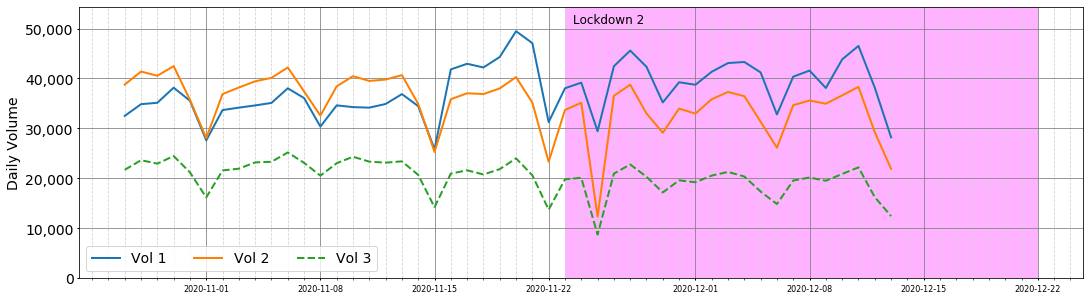

In [11]:
multi_linechart(df_multi, sett)

## Example: one shaded area with no legend
In this case, simply do not include `legend` in the settings dict.  

In [12]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'yaxis': {
        'label': 'Daily Volume'
    },
    'xaxis': {
         'major_loc': {
            'loc': mdates.DayLocator(),
            'date_form': mdates.DateFormatter('%Y-%m-%d')
        },
        'minor_loc': {
            'date_form': mdates.DayLocator(interval=1),  # every other day
        }
    },
   
    # grid
    'major_grid_on': True,
    'minor_grid_on': True,
    'minor_grid': {
        'stroke': '#D3D3D3',
        'border': '--'
    },
    
    # legend
#     'legend': {
#         'loc': 'lower left'
#     },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'font-size': 12, 
                'colour': 'k',
                'rotation': 0
            }
        }
    }
}

(<Figure size 1296x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0aeb082a58>)

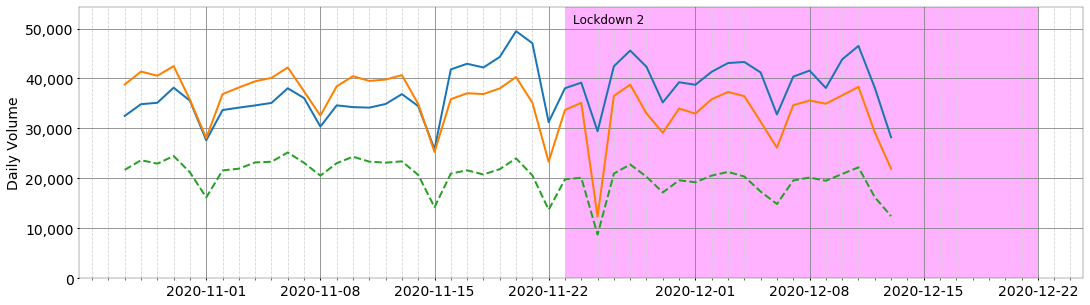

In [13]:
multi_linechart(df_multi, sett)

## Example: one shaded area block and shaded weekends

In [14]:
def find_weekend_indices(df):
    '''Outputs a 2D list of weekend date pairs given date column
    in df. Assumes first column of df is the date column. 
    Datetime pairs output in `datetime.date()` format.
    '''
    xcol=list(df)[0]
    datetime_array=df[xcol]
    
    s = []
    for i in range(len(datetime_array) - 1):
        if datetime_array[i].weekday() >= 5:
            s.append([df[xcol][i], df[xcol][i + 1]])

    return s

In [15]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'yaxis': {
        'label': 'Daily Volume'
    },
   'xaxis': {
        'major_loc': {
            'loc': mdates.DayLocator(),
            'date_form': mdates.DateFormatter('%Y-%m-%d')
        },
        'minor_loc': {
            'date_form': mdates.DayLocator(interval=1),  # every other day
        }
   },
    
    # grid
    'major_grid_on': True,
    'minor_grid_on': True,
    'minor_grid': {
        'stroke': '#D3D3D3',
        'border': '--'
    },
    
    # legend
    'legend': {
        'loc': 'lower left'
    },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'font-size': 12, 
                'colour': 'k',
                'rotation': 0
            }
        },
        1:{
            'lims':find_weekend_indices(df_multi),
            'fill': '#ccffff',
            'alpha': 0.9 
        }
    }
}

(<Figure size 1296x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0aeb2014a8>)

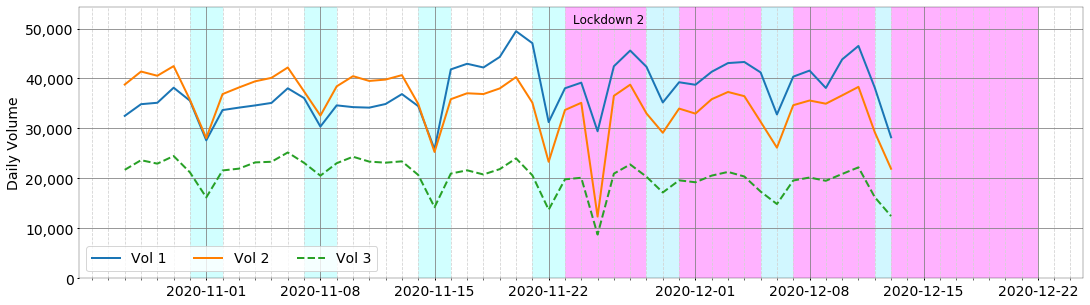

In [16]:
multi_linechart(df_multi, sett)

(<Figure size 1296x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ae976f400>)

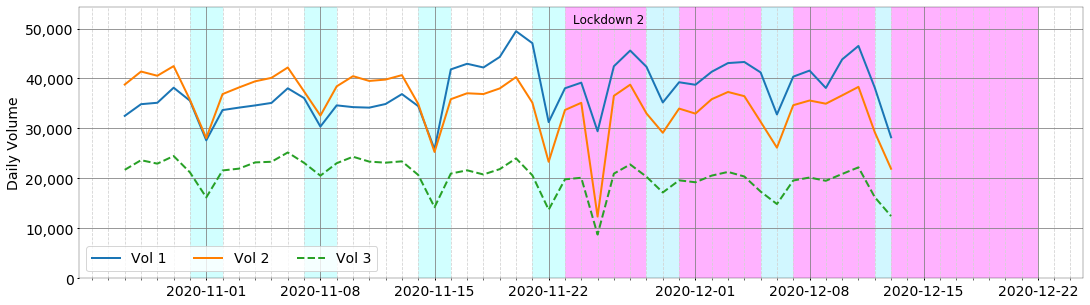

In [17]:
# From jupyterhub python 3.7.3 -- do not run this cell
multi_linechart(df_multi, sett)

# 2. Demo dataset 2: Time series, dt=week
*Recall: `multi_linechart()` expects dataframe with first column for the x-axis and subsequent columns for plotting on the y-axis.*  

Demo dataset 2 is a time series of interval one week. The x-axis labels will display major formatters at the beginning of each month with tick label format `Month 2020` with no minor formatters.   

In [18]:
# x-axis
dt=[datetime.date(2020, 3, 2), datetime.date(2020, 3, 9), datetime.date(2020, 3, 16),
 datetime.date(2020, 3, 23), datetime.date(2020, 3, 30), datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 13), datetime.date(2020, 4, 20), datetime.date(2020, 4, 27),
 datetime.date(2020, 5, 4), datetime.date(2020, 5, 11), datetime.date(2020, 5, 18),
 datetime.date(2020, 5, 25), datetime.date(2020, 6, 1), datetime.date(2020, 6, 8),
 datetime.date(2020, 6, 15), datetime.date(2020, 6, 22), datetime.date(2020, 6, 29),
 datetime.date(2020, 7, 6), datetime.date(2020, 7, 13), datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 27), datetime.date(2020, 8, 3), datetime.date(2020, 8, 10),
 datetime.date(2020, 8, 17), datetime.date(2020, 8, 24), datetime.date(2020, 8, 31),
 datetime.date(2020, 9, 7), datetime.date(2020, 9, 14), datetime.date(2020, 9, 21),
 datetime.date(2020, 9, 28), datetime.date(2020, 10, 5), datetime.date(2020, 10, 12),
 datetime.date(2020, 10, 19), datetime.date(2020, 10, 26), datetime.date(2020, 11, 2),
 datetime.date(2020, 11, 9), datetime.date(2020, 11, 16), datetime.date(2020, 11, 23),
 datetime.date(2020, 11, 30), datetime.date(2020, 12, 7), datetime.date(2020, 12, 14),
 datetime.date(2020, 12, 21)]

In [19]:
# y-axis
# line 1
y1=[3.02419154469977, 2.99366865138892, 3.01353809216413, 2.94186347516395, 
    2.91332271246307, 2.85854109197429, 2.76872546877112, 2.78244466517205, 
    2.80764274213638, 2.8278348673446, 2.86467544770234, 2.93833179196963, 
    3.04626618237813, 3.16676205506535, 3.28103887911297, 3.35355551396727, 
    3.34208204007746, 3.25669746732819, 3.17398421787229, 3.52702041518902, 
    3.36175550875315, 3.43543771859161, 3.46184881819421, 3.39627431340217, 
    3.45251678604306, 3.36192265573067, 3.28741494612631, 3.41652033593208, 
    3.43777865122018, 3.559692291405, 3.62069747424247, 3.53457172965231, 
    3.6070483160655, 3.453403523385, 3.36935265094359, 3.36505056886525, 
    3.36338414780305, 3.46275960914892, 3.57316348930405, 3.68714315432472, 
    3.66860658603494, 3.67472332954439, 3.76077270931965]

# line 2
y2=[3.3476508435181, 3.34162449143467, 3.29143411887978, 3.20832068142402, 
    3.0444437080988, 2.96262032539521, 2.87133674454897, 2.78501655455216, 
    2.8052951558961, 2.77239410340245, 2.895799536075, 3.08327480548404, 
    3.11639758687515, 3.08325346461171, 3.17695908159152, 3.11328424430024, 
    3.19594501163704, 3.3297219084822, 3.28634035925014, 3.12982527373787, 
    3.40590817897924, 3.46371365112992, 3.41350665405673, 3.46861429547781, 
    3.53659710047626, 3.51540618545213, 3.52835746425794, 3.49468728369239, 
    3.45740090923564, 3.60688753404378, 3.64078554093756, 3.7534552474586, 
    3.69179732241833, 3.61680979570243, 3.58041540692345, 3.55924344209829, 
    3.4953445280816, 3.42200446103196, 3.39171787006797, 3.33203969856659, 
    3.38935538041984, 3.43726313816507, 3.47380763318113]


In [20]:
data = {'dt':dt, 'y1':y1, 'y2':y2}

df_tt = pd.DataFrame(data) 

print(df_tt.shape)
df_tt.head()

(43, 3)


,dt,y1,y2
0,2020-03-02,3.024192,3.347651
1,2020-03-09,2.993669,3.341624
2,2020-03-16,3.013538,3.291434
3,2020-03-23,2.941863,3.208321
4,2020-03-30,2.913323,3.044444


In [21]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 16
    },
    
    # Title, Axes labels and limits
    'title': 'AM Peak Period',
    'title_params': {
        'font-size': 18,
        'loc': 'left'
    },
    'ticklength': 4,
    'yaxis': {
        'ymax': 5.7,
        'precision': '.1f',
        'label': 'Travel Time (min)'
    },
    'xaxis': {
       'major_loc': {
            'loc': mdates.DayLocator(),
            'date_form': mdates.DateFormatter('%Y-%m-%d')
        }
#         'minor_loc': {
#             'date_form': mdates.DayLocator(interval=1),  # every other day
#         }  
    },
   
    'major_grid_on': False, # or can omit this setting
    
    # legend
    'legend': {
        'loc': 'lower left'
    },

    'lines': {
        0: {
            'stroke': '#660159',
            'stroke-width': 4,
            'border-style': 'solid',
            'label': 'Southbound'
            },
        1: {
            'stroke': '#D95F02',
            'stroke-width': 4,
            'border-style': 'solid',
            'label': 'Northbound'
            }
    },
    
    'shaded': { 
        0: {
            'lims':[[pd.to_datetime('2020-05-18'), pd.to_datetime('2020-06-29')]],
            'fill': '#e1e1e1',
            'zorder':-100,
            'alpha': 0.5,
            'label': {
                'x': pd.to_datetime('2020-05-18') + datetime.timedelta(days=.5),
                'y': 5.3,
                'text': 'Before',
                'font-size': 16, 
                'colour': '#707070',
                'rotation': 90
            }
        },
        1: {
            'lims':[[pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13')]],
            'fill': '#e1e1e1',
            'zorder':-100,
            'alpha': 0.5,
            'label': {
                'x': pd.to_datetime('2020-07-06') + datetime.timedelta(days=.5),
                'y': 5.3,
                'text': 'Installation',
                'font-size': 16, 
                'colour': '#707070',
                'rotation': 90
            }
        },
        2: {
            'lims':[[pd.to_datetime('2020-07-27'), pd.to_datetime('2020-09-18')]],
            'fill': '#e1e1e1',
            'zorder':-100,
            'alpha': 0.5,
            'label': {
                'x': pd.to_datetime('2020-07-27') + datetime.timedelta(days=.5),
                'y': 5.35,
                'text': 'After',
                'font-size': 16, 
                'colour': '#707070',
                'rotation': 90
            }
        }
    }
}

findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.


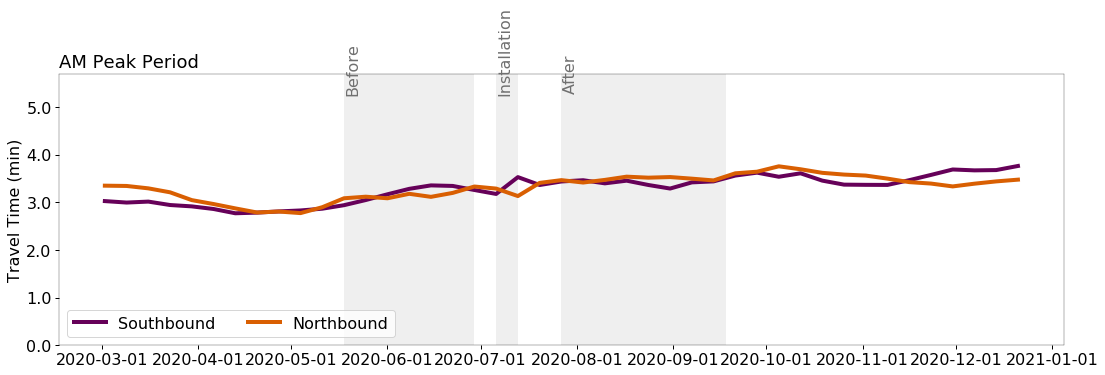

In [22]:
fig, ax = multi_linechart(df_tt, sett)

In [23]:
# fname='test_multi'
# plt.savefig(fname, dpi=300, bbox_inches='tight')